## Reinforcement Learning 2024
---
KHU

Soft Actor Critic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'/RL/SAC
!ls
import sys; sys.path.append('..') # add project root to the python path

In [ ]:
!pip install swig
!pip install gym[all]
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
from IPython.display import clear_output
import glob
import base64, io

# Network

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim,log_std_min=-20,log_std_max= 2):
        """Initialize."""
        super(Actor, self).__init__()

        # set the log std range
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        # set the hidden layers
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)

        # set log_std layer
        self.log_std_layer = nn.Linear(300, action_dim)

        # set mean layer
        self.mu_layer = nn.Linear(300, action_dim)

    def forward(self, state):
        """Forward method implementation."""

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # get mean
        mu = self.mu_layer(x).tanh()

        # get std
        log_std = self.log_std_layer(x).tanh()
        log_std = self.log_std_min + 0.5 * (
            self.log_std_max - self.log_std_min
        ) * (log_std + 1)
        std = torch.exp(log_std)

        # sample actions
        dist = Normal(mu, std)
        z = dist.rsample()

        # normalize action and log_prob
        # see appendix C of [2]
        action = z.tanh()
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-7)
        log_prob = log_prob.sum(-1, keepdim=True)

        return action,mu,log_prob


class CriticQ(nn.Module):
    def __init__(self, in_dim):

        super(CriticQ, self).__init__()

        self.fc1 = nn.Linear(in_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.out = nn.Linear(300, 1)

    def forward(self, state,action):

        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.out(x)

        return value


class CriticV(nn.Module):
    def __init__(self, in_dim: int):
        super(CriticV, self).__init__()

        self.fc1 = nn.Linear(in_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.out = nn.Linear(300, 1)

    def forward(self, state):

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.out(x)

        return value

# Replay Buffer

In [ ]:
class ReplayBuffer:

    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.s = np.zeros((max_size, state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.float32)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.ns = np.zeros((max_size, state_dim), dtype=np.float32)
        self.done = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, ns, done):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.ns[self.ptr] = ns
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (
            torch.FloatTensor(self.s[ind]),
            torch.FloatTensor(self.a[ind]),
            torch.FloatTensor(self.r[ind]),
            torch.FloatTensor(self.ns[ind]),
            torch.FloatTensor(self.done[ind]),
        )

# Soft Actor Critic (SAC)

1. [T. Haarnoja et al., "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." arXiv preprint arXiv:1801.01290, 2018.](https://arxiv.org/pdf/1801.01290.pdf)
2. [T. Haarnoja et al., "Soft Actor-Critic Algorithms and Applications." arXiv preprint arXiv:1812.05905, 2018.](https://arxiv.org/pdf/1812.05905.pdf)

The main purpose of SAC is to maximize the actor's entropy while maximizing expected reward. We can expect both sample efficient learning and stability because maximizing entropy provides a substantial improvement in exploration and robustness.

As an extension of standard RL's objective function $\sum_t \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t)]$, let's consider a more general maximum entropy objective which favors stochastic policies by augmenting the objective with the expected entropy of the policy over $\rho_\pi (s_t)$:

$$J(\pi) = \sum_{t=0}^T \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t) + \alpha H(\pi(\cdot | s_t))].$$

The temperature parameter $\alpha$ determines the relative importance of the entropy term against the reward, and thus controls the stochasticity of the optimal policy. By this objective, the policy can explore more widely and capture multiple modes of near-optimal behavior. In conclusion, it considerably improves learning speed over other methods that optimize the conventional RL objective function.

In the paper, the authors show that *Soft Policy Iteration* guarantees convergence based on a tabular setting (4.1), and they extend it to a practical approximation for large continuous domains (4.2). Firstly, the soft value function is trained to minimize the squared residual error:

$$J_V (\psi) = \mathbb{E}_{s_t \sim D} \big[ \frac{1}{2}(v_\psi (s_t) - \mathbb{E}_{a_t \sim \pi_\phi} [Q_\theta(s_t, a_t) - \log_{\pi_\phi}(a_t | s_t)])^2 \big],$$

where $D$ is the distribution of previously sampled states and actions, or a replay buffer. Second, the soft Q-function parameters can be trained to minimize the soft Bellman residual:

$$J_Q (\theta) = \mathbb{E}_{(s_t, a_t) \sim D} \big[ \frac{1}{2} \big( Q_\theta(s_t, a_t) - \hat{Q}(s_t, a_t) \big)^2 \big],$$

with $\hat{Q}(s_t, a_t) = r(s_t, a_t) + \gamma \mathbb{E}_{s_{t+1} \sim \rho} [V_{\tilde{\psi}} (s_{t+1})].$

Finally, the policy paramameters can be learned by directly minimizing the following expected KL-divergence:

$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D} \big[ D_{KL} \big( \pi_{\phi} (\cdot | s_t) \| \frac{\exp(Q_{\theta}(s_t, \cdot))}{Z_\theta(s_t)} \big) \big].$$

We can rewirte the objective as

$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D, \epsilon_t \sim N} [ \log_{\pi_\phi}(f_\phi(\epsilon_t ; s_t) | s_t) - Q_\theta (s_t, f_\phi (\epsilon_t ; s_t))],$$

where $\pi_\phi$ is defined implicitly in terms of $f_\phi$, and the partition function is independent of $\phi$ and can thus be omitted.

One thing to note is that the authors suggest to use two Q-functions to mitigate positive bias in the policy improvement step that is known to degrade performance of value based methods. In particular, we parameterize two Q-functions, with parameters $\theta_i$, and train them independently to optimize $J_Q(\theta_i)$. We then use the minimum of the Q-functions for the value gradient and policy gradient. Two Q-functions can significantly speed up training, especially on harder tasks.

### Can we do better?

In Soft Actor Critic paper, the experiment of reward scale shows that SAC's performance quite varies depending on reward scaling. In the follow-up paper [2], the authors assume that the temperature parameter $\alpha$ needs to be adjusted depending on the magnitude of the reward, and they define the soft policy optimization as a constrained problem.

$$\max_{\pi_{0:T}} \mathbb{E}_{\rho_\pi} \big[ \sum_{t=0}^T r(s_t, a_t) \big] \text{ s.t. } \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [-\log(\pi_t(a_t|s_t))] \ge H \text{ for all } t,$$

where $H$ is a desired minimum expected entropy. This constrained maximization becomes the following dual problem.

$$\min_{a_T \ge 0} \max_{\pi_T} \mathbb{E} [r(s_T, a_T) - \alpha_T \log \pi(a_t|s_t)] - \alpha_T H,$$

where $\alpha_T$ is the dual variable. Furthermore, it can be rewrited as a optimization problem with regards to $\alpha$.

$$J(\alpha) = \mathbb{E}_{a_t \sim \pi_t} [-\alpha \log \pi_t (a_t | s_t) - \alpha H].$$

By optimizing this dual problem, we can adjust the dual variable $\alpha$, which plays the role of the temperature.

https://wikidocs.net/169331

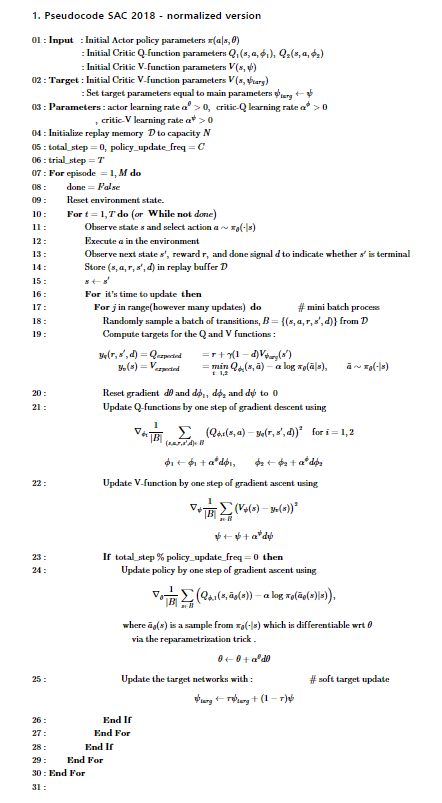

In [ ]:
class SAC:
    def __init__(
            self,
            state_dim,
            action_dim,
            lr=0.00025,
            gamma=0.99,
            batch_size=128,
            warmup_steps=5000,
            tau=5e-3,
            buffer_size=int(1e6),
    ):
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.tau = tau


        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        self.policy_update_freq = 2

        # automatic entropy tuning
        self.target_entropy = -np.prod((action_dim,)).item()  # heuristic
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=lr)

        # actor
        self.actor = Actor(state_dim, action_dim).to(self.device)

        # v function
        self.vf = CriticV(state_dim).to(self.device)
        self.vf_target = CriticV(state_dim).to(self.device)
        self.vf_target.load_state_dict(self.vf.state_dict())

        # q function
        self.qf_1 = CriticQ(state_dim + action_dim).to(self.device)
        self.qf_2 = CriticQ(state_dim + action_dim).to(self.device)

        # optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.vf_optimizer = optim.Adam(self.vf.parameters(), lr=lr)
        self.qf_1_optimizer = optim.Adam(self.qf_1.parameters(), lr=lr)
        self.qf_2_optimizer = optim.Adam(self.qf_2.parameters(), lr=lr)

        self.buffer = ReplayBuffer(state_dim, (2,), buffer_size)

        self.total_steps = 0

    def select_action(self, x,training=True):

        if training:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            action,mu,log_prob = self.actor(x)
            action=action.detach().cpu().numpy()[0]
            mu=mu.detach().cpu().numpy()[0]
            log_prob=log_prob.detach().cpu().numpy()[0]

            return action

        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            action,mu,log_prob = self.actor(x)
            action=action.detach().cpu().numpy()[0]
            mu=mu.detach().cpu().numpy()[0]
            log_prob=log_prob.detach().cpu().numpy()[0]

            return mu


    def update_model(self):

        s, a, r, ns, done = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))

        new_action,mu, log_prob = self.actor(s)

        # train alpha (dual problem)
        alpha_loss = (
            -self.log_alpha.exp() * (log_prob + self.target_entropy).detach()
        ).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        alpha = self.log_alpha.exp()  # used for the actor loss calculation

        # q function loss
        mask = 1 - done
        q_1_pred = self.qf_1(s, a)
        q_2_pred = self.qf_2(s, a)
        v_target = self.vf_target(ns)
        q_target = r + self.gamma * v_target * mask
        qf_1_loss = F.mse_loss(q_1_pred, q_target.detach())
        qf_2_loss = F.mse_loss(q_2_pred, q_target.detach())

        # v function loss
        v_pred = self.vf(s)
        q_pred = torch.min(
            self.qf_1(s, new_action), self.qf_2(s, new_action)
        )
        v_target = q_pred - alpha * log_prob
        vf_loss = F.mse_loss(v_pred, v_target.detach())


        if self.total_steps % self.policy_update_freq == 0:
            # actor loss
            advantage = q_pred - v_pred.detach()
            actor_loss = (alpha * log_prob - advantage).mean()

            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # target update (vf)
            self._target_soft_update()
        else:
            actor_loss = torch.zeros(1)

        # train Q functions
        self.qf_1_optimizer.zero_grad()
        qf_1_loss.backward()
        self.qf_1_optimizer.step()

        self.qf_2_optimizer.zero_grad()
        qf_2_loss.backward()
        self.qf_2_optimizer.step()

        qf_loss = qf_1_loss + qf_2_loss

        # train V function
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step()

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau

        for t_param, l_param in zip(
            self.vf_target.parameters(), self.vf.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)


    def process(self, transition):

        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps>self.warmup_steps:
          self.update_model()

In [ ]:
env = gym.make('LunarLander-v2', continuous=True)

max_steps = int(1e6)
eval_interval = 10000
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = SAC(state_dim, action_dim)

In [ ]:
def evaluate(n_evals=1):
    eval_env = gym.make('LunarLander-v2', continuous=True)

    scores = 0
    for i in range(n_evals):
        s, done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.select_action(s,training=False)
            s_prime, r, terminated, _ = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated
        scores += ret
    return np.round(scores / n_evals, 4)

In [ ]:
history = {'Step': [], 'AvgReturn': []}
s= env.reset()
score = -1e6
rewards=0


while True:

    if agent.total_steps < agent.warmup_steps:
        a = env.action_space.sample()
    else:
        a = agent.select_action(s,training=True)

    ns, r, done,_ = env.step(a)
    # Update
    agent.process((s, a, r, ns, done))
    s = ns
    rewards+=r
    if done  or rewards<-250:
        s = env.reset()
        rewards=0

    if agent.total_steps % eval_interval == 0:
        avgreturn = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(avgreturn)

        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()

        if score < avgreturn:
            score = avgreturn
            torch.save(agent.actor.state_dict(), 'sac.pt')

    if agent.total_steps > max_steps:
        break

# Visualize

In [ ]:
!mkdir video
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(policy, env_name):


    env = gym.make(env_name,continuous=True)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.actor.load_state_dict(torch.load('sac.pt'))
    s = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        a = agent.select_action(s,training=False)
        ns, r, done, _ = env.step(a)
        s=ns

    env.close()

In [ ]:
show_video_of_model(agent, 'LunarLander-v2')

In [ ]:
show_video('LunarLander-v2')